# Plot of velocity v/s distance from a diagonal cut from the C18O map moment 1

This test was made to see if something could be said about the disk rotation using the moment 1 only. We really cannot say much from this. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from scipy import ndimage
from pvextractor import PathFromCenter
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import sys
sys.path.append('../B5_NOEMA_30m')
from B5setup import *
from skimage import measure
import aplpy

In [2]:
savefolder = 'rotation_profiles/'
mom1imagename = 'cleaned_images/B5IRS1_C18O_robust05_multi_mom1.fits'
cubefile = 'cleaned_images/B5IRS1_C18O_robust05_multi.fits'
pa_angle = 157.1 #degrees from north

In [10]:
# we load the cube to obtain the errors
cubeheader = fits.getheader(cubefile)
chanwidth = np.abs(cubeheader['CDELT3']) *1e-3 # in km/s
velunc = chanwidth/1.175
fluxunc_frac = 0.1 # flux uncertainty is around 10%

In [11]:
chanwidth

0.041666750385070006

## Profile obtained with PA=157.1 deg (obtained from outflow)

In [4]:
mom1image = fits.getdata(mom1imagename)
mom1unc = mom1image * 2*fluxunc_frac + np.ones(np.shape(mom1image))*velunc
mom1header = fits.getheader(mom1imagename)
mom1wcs = WCS(mom1header)
#central position of the line
centerxdeg, centerydeg = 56.9232792*u.deg, 32.8621161*u.deg # center taken from mom1 image
# centerxdeg, centerydeg = ra_yso*u.deg, dec_yso*u.deg
length= 0.0011
pathcenter = PathFromCenter(SkyCoord(centerxdeg, centerydeg), length*u.deg, angle=pa_angle*u.deg)
pathcoords = pathcenter._coords
(xend, xstart), (yend, ystart) = mom1wcs.wcs_world2pix(pathcoords.ra, pathcoords.dec,0)
centerxpix, centerypix = mom1wcs.all_world2pix(centerxdeg, centerydeg, 0)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [5]:
samplenum = np.amax([int(np.abs(xstart-xend)+1), int(np.abs(ystart-yend)+1)])
xlist, ylist = np.linspace(xend,xstart, samplenum), np.linspace(yend, ystart, samplenum)
distancepix = np.sqrt((xlist-centerxpix)**2+(ylist-centerypix)**2) * np.sign(xlist-centerxpix)
distanceau = distancepix * mom1header['CDELT2'] * 3600 * 302 # au
mom1eval = mom1image.copy()
mom1unceval = mom1unc.copy()
mom1eval[np.where(np.isnan(mom1image))] = 0
mom1unceval[np.where(np.isnan(mom1image))] = 0
zi = ndimage.map_coordinates(np.transpose(mom1eval), np.vstack((xlist, ylist)))
ziunc = ndimage.map_coordinates(np.transpose(mom1unceval), np.vstack((xlist, ylist)))

In [12]:
ziunc

array([1.96752064, 1.96797049, 1.96769849, 1.96933812, 1.97157682,
       1.96242547, 1.95615834, 1.95952273, 1.95552307, 1.95181395,
       1.94928175, 1.94455343, 1.94945295, 1.94986195, 1.94936927,
       1.95377738, 1.95015193, 1.94346504, 1.94403427, 1.93259161,
       1.93164402, 1.91862606, 1.91018188, 1.88906729, 1.89049764,
       1.86832301, 1.83913634, 1.82521548, 1.80978542, 1.80836898,
       1.8117046 , 1.84740904, 1.89170742, 1.9550157 , 2.05208831,
       2.13862389, 2.22940603, 2.23663474, 2.23297414, 2.22473532,
       2.21436657, 2.19397711, 2.17603884, 2.16131894, 2.12688488,
       2.11333824, 2.10701695, 2.09955425, 2.09233682, 2.08215068,
       2.07568631, 2.06877185, 2.0634987 , 2.05240225, 2.04696952,
       2.04518798, 2.04110202, 2.03386602, 2.0263438 , 2.02016622,
       2.01812399, 2.02239467, 2.02623843, 2.02602974, 2.01560684,
       1.99185749, 1.96410127, 1.96110986])

In [6]:
def v_kepler(mass, radius):
    vel = np.sqrt(G * mass / radius)
    return vel
from astropy.constants import G

In [7]:
radius_au = np.linspace(50, 200) * u.au
M_star = 0.1* u.Msun
vel_kep_mass = v_kepler(M_star, radius_au).decompose().to(u.km/u.s).value
M_star2 = 0.2 * u.Msun
vel_kep_mass2 = v_kepler(M_star2, radius_au).decompose().to(u.km/u.s).value

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


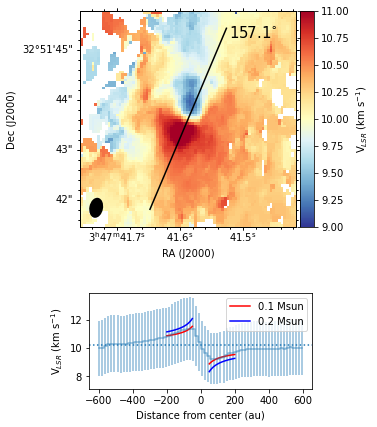

In [13]:
# we plot to check we are extracting the right line
fig = plt.figure(figsize=(4,6))
ax = fig.add_gridspec(3,1)
ax1 = aplpy.FITSFigure(mom1imagename, figure=fig, subplot=[0, 0.5, 1, 0.5])
ax1.show_colorscale(cmap='RdYlBu_r', vmin=9, vmax=11)
ax1.add_colorbar()
ax1.colorbar.set_axis_label_text(r'V$_{LSR}$ (km s$^{-1}$)')
ax1.add_beam(facecolor='k')
ax1.recenter(centerxdeg, centerydeg, 0.0006)
ax1.show_lines(np.array([mom1wcs.all_pix2world((xstart, xend), (ystart, yend),0)]), color='k')
ax1.add_label(0.8, 0.9, r'157.1$^{\circ}$', relative=True, size=15)
ax2 = fig.add_subplot(ax[2,0]) 
# ax2.plot(distanceau, zi, 'k.')
# ax2.plot(distanceau, zi, 'k-', drawstyle='steps-mid', alpha=0.5)
ax2.errorbar(distanceau, zi, yerr=ziunc, drawstyle='steps-mid', alpha=0.5)
ax2.set_xlabel('Distance from center (au)')
ax2.set_ylabel(r'V$_{LSR}$ (km s$^{-1}$)')
ax2.axhline(10.2, linestyle='dotted')
ax2.plot(-radius_au, vel_kep_mass  + 10.2, color='r', ls='-', label='0.1 Msun')
ax2.plot(radius_au, -vel_kep_mass  + 10.2, color='r', ls='-')
ax2.plot(-radius_au, vel_kep_mass2  + 10.2, color='b', ls='-', label='0.2 Msun')
ax2.plot(radius_au, -vel_kep_mass2  + 10.2, color='b', ls='-')
ax2.legend()
fig.savefig(savefolder + 'mom1_velocity_vs_distance_profile_157deg_werror.pdf', bbox_inches='tight')

## Plot with different inclination angles

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


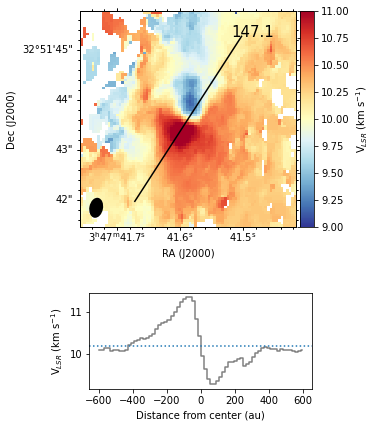

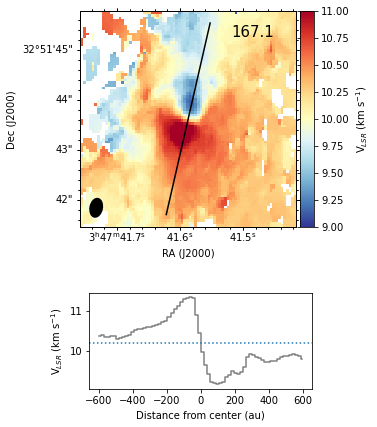

In [28]:
pa_anglelist = [157.1-10, 157.1+10]
for pa_angle in pa_anglelist:
    pathcenter = PathFromCenter(SkyCoord(centerxdeg, centerydeg), length*u.deg, angle=pa_angle*u.deg)
    pathcoords = pathcenter._coords
    (xend, xstart), (yend,ystart) = mom1wcs.wcs_world2pix(pathcoords.ra, pathcoords.dec,0)
    
    xlist, ylist = np.linspace(xend,xstart, samplenum), np.linspace(yend, ystart, samplenum)
    distancepix = np.sqrt((xlist-centerxpix)**2+(ylist-centerypix)**2) * np.sign(xlist-centerxpix)
    distanceau = distancepix * mom1header['CDELT2'] * 3600 * 302 # au
    mom1eval = mom1image.copy()
    mom1eval[np.where(np.isnan(mom1image))] = 0
    zi = ndimage.map_coordinates(np.transpose(mom1eval), np.vstack((xlist, ylist)))
    
    fig = plt.figure(figsize=(4,6))
    ax = fig.add_gridspec(3,1)
    ax1 = aplpy.FITSFigure(mom1imagename, figure=fig, subplot=[0, 0.5, 1, 0.5])
    ax1.show_colorscale(cmap='RdYlBu_r', vmin=9, vmax=11)
    ax1.add_colorbar()
    ax1.colorbar.set_axis_label_text(r'V$_{LSR}$ (km s$^{-1}$)')
    ax1.add_beam(facecolor='k')
    ax1.recenter(centerxdeg, centerydeg, 0.0006)
    ax1.show_lines(np.array([mom1wcs.all_pix2world((xstart, xend), (ystart, yend),0)]), color='k')
    ax1.add_label(0.8, 0.9, str(np.round(pa_angle, 1)), relative=True, size=15)
    ax2 = fig.add_subplot(ax[2,0]) 
    # ax2.plot(distanceau, zi, 'k.')
    ax2.plot(distanceau, zi, 'k-', drawstyle='steps-mid', alpha=0.5)
    ax2.set_xlabel('Distance from center (au)')
    ax2.set_ylabel(r'V$_{LSR}$ (km s$^{-1}$)')
    ax2.axhline(10.2, linestyle='dotted')
    fig.savefig(savefolder + 'mom1_velocity_vs_distance_profile_{}deg.pdf'.format(np.round(pa_angle, 1))
                , bbox_inches='tight')